In [1]:
!pip install torch torchvision torchaudio --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 831.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 844.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = '/content/drive/MyDrive/Assignment2/Assignment2/dataset/Pride_and_Prejudice-Jane_Austen.txt'
with open(dataset_path, 'r', encoding='utf-8') as f:
    text = f.read()
print(text[:500])  # print first 500 characters as a check

The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: Jane Austen

Editor: R. W. (Robert William) Chapman

Release Date: May 9, 2013  [eBook #42671]

Lang


In [5]:
tokens = text.split()

In [6]:
unique_tokens = sorted(set(tokens))
vocab = {token: idx for idx, token in enumerate(unique_tokens)}

In [7]:
encoded_text = [vocab[token] for token in tokens]

print(f"Number of tokens in dataset: {len(tokens)}")
print(f"Vocabulary size: {len(vocab)}")
print(f"First 10 tokens: {tokens[:10]}")
print(f"First 10 encoded tokens: {encoded_text[:10]}")

Number of tokens in dataset: 124970
Vocabulary size: 13777
First 10 tokens: ['The', 'Project', 'Gutenberg', 'eBook,', 'Pride', 'and', 'Prejudice,', 'by', 'Jane', 'Austen,']
First 10 encoded tokens: [1495, 1350, 902, 5187, 1347, 2385, 1345, 3268, 1011, 524]


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

In [9]:
sequence_length = 5
batch_size = 32

In [10]:
class TextDataset(Dataset):
    def __init__(self, encoded_text, seq_len):
        self.encoded_text = encoded_text
        self.seq_len = seq_len

    def __len__(self):
        return len(self.encoded_text) - self.seq_len

    def __getitem__(self, idx):
        # Input sequence
        x = torch.tensor(self.encoded_text[idx:idx+self.seq_len], dtype=torch.long)
        # Target sequence (next tokens)
        y = torch.tensor(self.encoded_text[idx+1:idx+1+self.seq_len], dtype=torch.long)
        return x, y

In [11]:
dataset = TextDataset(encoded_text, sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
for x_batch, y_batch in dataloader:
    print("Input batch shape:", x_batch.shape)   # (batch_size, sequence_length)
    print("Target batch shape:", y_batch.shape)  # (batch_size, sequence_length)
    break

Input batch shape: torch.Size([32, 5])
Target batch shape: torch.Size([32, 5])


In [13]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMLanguageModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: batch of token indices, shape (batch_size, seq_length)
        embed = self.embedding(x)  # (batch_size, seq_length, embed_size)

        if hidden is None:
            output, hidden = self.lstm(embed)
        else:
            output, hidden = self.lstm(embed, hidden)

        # output shape: (batch_size, seq_length, hidden_size)
        logits = self.fc(output)  # (batch_size, seq_length, vocab_size)

        return logits, hidden

In [14]:
import torch.optim as optim

In [15]:
embed_size = 128
hidden_size = 256
num_layers = 2
num_epochs = 10
learning_rate = 0.002

In [16]:
model = LSTMLanguageModel(len(vocab), embed_size, hidden_size, num_layers)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def train_with_loss_plot(model, dataloader, criterion, optimizer, device, num_epochs):
    model.train()
    epoch_losses = [] # To store average loss per epoch
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)

            # Reshape outputs and targets for calculating loss
            loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return epoch_losses

In [20]:
train_with_loss_plot(model, dataloader, criterion, optimizer, device, num_epochs)

Epoch [1/10], Loss: 5.4600
Epoch [2/10], Loss: 3.6213
Epoch [3/10], Loss: 2.7335
Epoch [4/10], Loss: 2.2789
Epoch [5/10], Loss: 2.0242
Epoch [6/10], Loss: 1.8718
Epoch [7/10], Loss: 1.7765
Epoch [8/10], Loss: 1.7109
Epoch [9/10], Loss: 1.6639
Epoch [10/10], Loss: 1.6313


[5.460025337983936,
 3.621266326291465,
 2.7335194636782925,
 2.2789355284790473,
 2.0241518360617463,
 1.871765158998008,
 1.7765392159658766,
 1.7109059516552223,
 1.6639318207686093,
 1.6313355245226417]

In [21]:
torch.save(model.state_dict(), 'trained_language_model.pth')

In [22]:
import math

def evaluate_prediction_difficulty(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    prediction_difficulty = math.exp(avg_loss)
    return prediction_difficulty

prediction_difficulty = evaluate_prediction_difficulty(model, dataloader, criterion, device)
print(f'Validation Prediction Difficulty: {prediction_difficulty:.2f}')

Validation Prediction Difficulty: 4.25


In [23]:
def run_experiments(vocab_size, dataloader, val_dataloader, criterion, device, experiment_configs, num_epochs=5):
    results = []
    for i, config in enumerate(experiment_configs):
        print(f"\n=== Experiment {i+1}: {config} ===")

        model = LSTMLanguageModel(
            vocab_size=vocab_size,
            embed_size=config['embed_size'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers']
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

        # Train the model
        train_with_loss_plot(model, dataloader, criterion, optimizer, device, num_epochs)

        # Evaluate on validation set
        val_score = evaluate_prediction_difficulty(model, val_dataloader, criterion, device)  # change name if you renamed perplexity

        print(f"Validation Score (Prediction Difficulty): {val_score:.2f}")

        results.append({
            'config': config,
            'validation_score': val_score,
            'model': model
        })

    return results

# Define experiment configurations for different fitting cases
experiment_configs = [
    # Underfitting: Small model, fewer epochs
    {'embed_size': 64, 'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.01},
    # Overfitting: Large model, more epochs
    {'embed_size': 256, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.001},
    # Best fit: Medium model, medium epochs
    {'embed_size': 128, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.002}
]

# Run experiments (Assuming you have val_dataloader ready)
# results = run_experiments(len(vocab), dataloader, val_dataloader, criterion, device, experiment_configs, num_epochs=10)


In [24]:
from torch.utils.data import random_split, DataLoader

In [25]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

In [26]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [27]:
batch_size = 32

In [28]:
rain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 99972, Validation samples: 24993


In [29]:

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [30]:
experiment_configs = [
    {'embed_size': 64, 'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.01},
    {'embed_size': 256, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.001},
    {'embed_size': 128, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.002}
]


In [31]:
results = run_experiments(len(vocab), train_dataloader, val_dataloader, criterion, device, experiment_configs, num_epochs=10)



=== Experiment 1: {'embed_size': 64, 'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.01} ===
Epoch [1/10], Loss: 5.4333
Epoch [2/10], Loss: 4.1722
Epoch [3/10], Loss: 3.7723
Epoch [4/10], Loss: 3.5605
Epoch [5/10], Loss: 3.4343
Epoch [6/10], Loss: 3.3481
Epoch [7/10], Loss: 3.2929
Epoch [8/10], Loss: 3.2500
Epoch [9/10], Loss: 3.2165
Epoch [10/10], Loss: 3.1958
Validation Score (Prediction Difficulty): 36.35

=== Experiment 2: {'embed_size': 256, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.001} ===
Epoch [1/10], Loss: 6.0417
Epoch [2/10], Loss: 4.5556
Epoch [3/10], Loss: 3.5344
Epoch [4/10], Loss: 2.8049
Epoch [5/10], Loss: 2.3070
Epoch [6/10], Loss: 1.9694
Epoch [7/10], Loss: 1.7458
Epoch [8/10], Loss: 1.5999
Epoch [9/10], Loss: 1.5042
Epoch [10/10], Loss: 1.4422
Validation Score (Prediction Difficulty): 12.89

=== Experiment 3: {'embed_size': 128, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.002} ===
Epoch [1/10], Loss: 5.7184
Epoch [2/10], Loss: 3.9652

In [34]:
import numpy as np

def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience=3):
    model.train()
    best_val_loss = np.inf
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        total_train_loss = 0
        # Training loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loss computation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                val_loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save best model weights
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break
        model.train()
    return train_losses, val_losses

Epoch 1: Train Loss: 5.7193, Val Loss: 4.7457
Epoch 2: Train Loss: 3.9793, Val Loss: 3.7444
Epoch 3: Train Loss: 3.0049, Val Loss: 3.2296
Epoch 4: Train Loss: 2.4699, Val Loss: 2.9570
Epoch 5: Train Loss: 2.1533, Val Loss: 2.7855
Epoch 6: Train Loss: 1.9533, Val Loss: 2.7003
Epoch 7: Train Loss: 1.8234, Val Loss: 2.6351
Epoch 8: Train Loss: 1.7359, Val Loss: 2.5828
Epoch 9: Train Loss: 1.6725, Val Loss: 2.5682
Epoch 10: Train Loss: 1.6274, Val Loss: 2.5624
Epoch 11: Train Loss: 1.5921, Val Loss: 2.5467
Epoch 12: Train Loss: 1.5654, Val Loss: 2.5416
Epoch 13: Train Loss: 1.5443, Val Loss: 2.5314
Epoch 14: Train Loss: 1.5212, Val Loss: 2.5386
Epoch 15: Train Loss: 1.5098, Val Loss: 2.5502
Epoch 16: Train Loss: 1.4978, Val Loss: 2.5460
Epoch 17: Train Loss: 1.4871, Val Loss: 2.5402
Epoch 18: Train Loss: 1.4790, Val Loss: 2.5455
Early stopping triggered


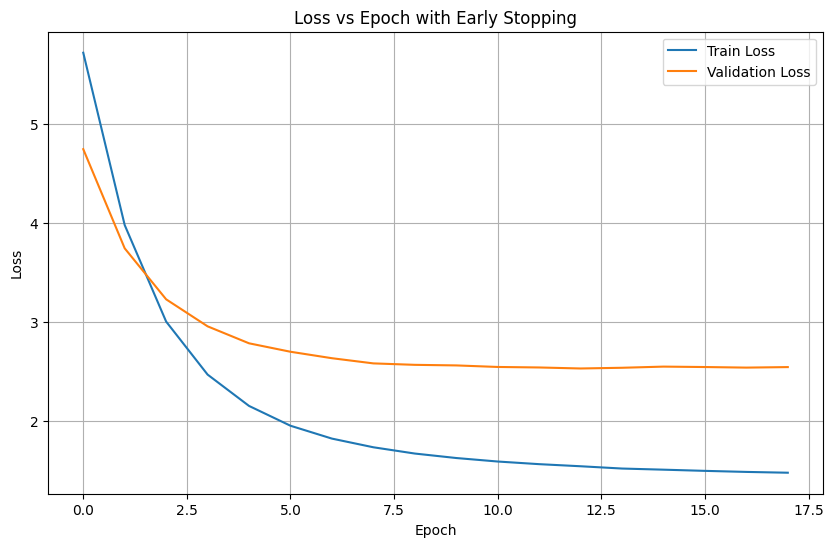

In [35]:
import matplotlib.pyplot as plt

# First, train a model using the `train_with_early_stopping` function
# We'll use one of the configurations from the previous experiments as an example
# For instance, let's use the 'best fit' configuration
config = experiment_configs[2]

# Re-initialize the model, optimizer, and criterion for this training run
model_es = LSTMLanguageModel(
    vocab_size=len(vocab),
    embed_size=config['embed_size'],
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers']
).to(device)
optimizer_es = torch.optim.Adam(model_es.parameters(), lr=config['learning_rate'])

# Call the modified train_with_early_stopping function to get losses
train_losses, val_losses = train_with_early_stopping(
    model_es, train_dataloader, val_dataloader, criterion, optimizer_es, device, num_epochs=20, patience=5
)

# Now plot the collected losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch with Early Stopping')
plt.grid(True)
plt.show()

In [40]:
idx_to_token = {idx: token for token, idx in vocab.items()}

In [41]:
def generate_text_adv(model, vocab, idx_to_token, start_tokens, generate_len=50, temperature=0.8):
    model.eval()
    device = next(model.parameters()).device
    input_seq = torch.tensor([vocab[token] for token in start_tokens], dtype=torch.long).unsqueeze(0).to(device)
    generated = start_tokens[:]
    hidden = None

    for _ in range(generate_len):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token_idx = torch.multinomial(probs, num_samples=1).item()
        next_token = idx_to_token[next_token_idx]
        generated.append(next_token)
        input_seq = torch.tensor([[next_token_idx]], dtype=torch.long).to(device)

    return ' '.join(generated)

# Example usage
print(generate_text_adv(model, vocab, idx_to_token, ['Elizabeth', 'was']))


Elizabeth was soon lost to every thing right to press the subject, from the danger of raising expectations which might only end in disappointment; for in the confusion, of whom he had felt the smallest interest, and from none of its animation, and besides, it was that Charlotte Lucas came to be


In [42]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

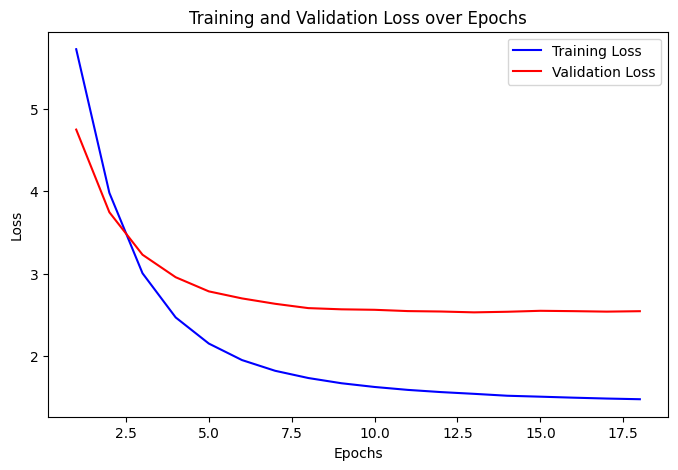

In [44]:
plot_loss(train_losses, val_losses)